# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!rm -Rf sample_data
!cp /content/drive/MyDrive/DLProject/NLI/dataset.csv .

In [3]:
!pip install transformers

In [4]:
!pip install pickle5

# Load & Visualize Dataset

In [5]:
import pickle5 as pkl
import pandas as pd

In [6]:
df = pkl.load(open('dataset.csv', "rb"))
df.head()

,journal_id,sentence_id,learning_language,native_language,sentence_text
0,728457,216037,English,Japanese,About winter
1,728457,216037,English,Japanese,This is my second post.
2,728457,216037,English,Japanese,I will appreciate it if you correct my sentences.
3,728457,216037,English,Japanese,It's been getting colder these days here in Ja...
4,728457,216037,English,Japanese,The summer weather in Japan is not agreeable t...


In [7]:
df = df.iloc[:, -2:]
df.head()

,native_language,sentence_text
0,Japanese,About winter
1,Japanese,This is my second post.
2,Japanese,I will appreciate it if you correct my sentences.
3,Japanese,It's been getting colder these days here in Ja...
4,Japanese,The summer weather in Japan is not agreeable t...


In [8]:
df['native_language'].unique()

array(['Japanese', 'Korean', 'Vietnamese', 'Mandarin', 'German',
       'Traditional Chinese', 'Russian', 'Thai', 'Spanish', 'Hebrew',
       'Portuguese(Brazil)', 'Cantonese', 'French', 'Italian',
       'Mongolian', 'Polish', 'English', 'Afrikaans', 'Greek', 'Turkish',
       'Farsi', 'Indonesian', 'Ukrainian', 'Catalan', 'Urdu', 'Latvian',
       'Arabic', 'Other language', 'Hindi', 'Croatian', 'Malaysian',
       'Romanian', 'Hungarian', 'Finnish', 'Portuguese(Portugal)',
       'Czech', 'Swedish', 'Dutch', 'Lithuanian', 'Tagalog', 'Danish',
       'Norwegian', 'Javanese', 'Tamil', 'Bosnian', 'Telugu', 'Sinhalese',
       'Bulgarian', 'Azerbaijanian', 'Uzbek', 'Serbian', 'Slovak',
       'Laotian', 'Icelandic', 'Armenian', 'Khmer', 'Georgian',
       'Esperanto', 'Slovenian', 'Estonian', 'Bengali', 'Panjabi',
       'Swahili', 'Albanian', 'Latin', 'Welsh'], dtype=object)

In [9]:
df['native_language'].value_counts()

Japanese               2154513
Mandarin                302914
Korean                  293221
Traditional Chinese     164596
Russian                  71509
                        ...   
Georgian                    16
Swahili                     11
Icelandic                    6
Laotian                      3
Albanian                     2
Name: native_language, Length: 66, dtype: int64

In [10]:
df.size

6404718

In [11]:
df = df[df['native_language'].isin(['German', 'Spanish', 'French'])]
# df = df[df['native_language'].isin(['German', 'Spanish', 'French', 'Japanese'])]
# df = df.drop(df.query('native_language == "Japanese"').sample(frac=.0.993).index)me
df['native_language'].unique()

array(['German', 'Spanish', 'French'], dtype=object)

In [12]:
df['native_language'].value_counts()

Spanish    26642
French     12500
German      9316
Name: native_language, dtype: int64

In [13]:
df.size

96916

In [14]:
labels = df.native_language.unique()
labels_dict = {}
for idx, label in enumerate(labels):
  labels_dict[label] = idx
labels_dict

{'French': 2, 'German': 0, 'Spanish': 1}

In [15]:
df['label'] = df.native_language.replace(labels_dict)
df.head()

,native_language,sentence_text,label
896,German,Really bad english teacher,0
897,German,"Hello,",0
898,German,I am 19 years old.,0
899,German,I began to learn english when I was about 16 y...,0
900,German,I had for about four years english now.,0


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    df.index.values,
    df.label.values,
    test_size=0.2,
    random_state=42,
    stratify=df.label.values   
)

df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'
df.groupby(['native_language', 'label', 'data_type']).count()

sentence_text
native_language label data_type               
French          2     train              10000
                      val                 2500
German          0     train               7453
                      val                 1863
Spanish         1     train              21313
                      val                 5329

In [17]:
validation_sentences = df[df.data_type=='val'].sentence_text.values
df[df.data_type=='val']

,native_language,sentence_text,label,data_type
897,German,"Hello,",0,val
898,German,I am 19 years old.,0,val
900,German,I had for about four years english now.,0,val
901,German,For four weeks I was in the UK to learn english.,0,val
905,German,In my opinion my engilsh skills went some step...,0,val
...,...,...,...,...
3199144,French,"To the eyes of jealous women , it would be a 1...",2,val
3199145,French,"At only 15 years old, she received what she ha...",2,val
3199146,French,Even what seemed impossible become possible an...,2,val
3199147,French,"He took care , was attentive, gentleman so wha...",2,val


# Models

In [18]:
import torch
from torch.utils.data import TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].sentence_text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=512,
    truncation=True,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].sentence_text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=512,
    truncation=True,
    return_tensors='pt'    
)

In [20]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [21]:
  model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(labels_dict),
    output_attentions=False,
    output_hidden_states=False
).to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [22]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 64
dataloader_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size,
    drop_last=True
)

dataloader_val = DataLoader(
    dataset_val,
    sampler=SequentialSampler(dataset_val),
    batch_size=batch_size
)

# Functions

In [23]:
import random
import numpy as np

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)  
torch.cuda.manual_seed_all(seed_val)

In [24]:
def accuracy_per_class(preds, labels, print=False):
  label_dict_inverse = {v:k for k,v in labels_dict.items()}
  preds_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  acc = {}
  total = 0
  for label in np.unique(labels_flat):
    y_preds = preds_flat[labels_flat==label]
    y_true = labels_flat[labels_flat==label]
    acc[label_dict_inverse[label]] = len(y_preds[y_preds==label])/len(y_true)
    total += acc[label_dict_inverse[label]]
    if print:
      tqdm.write(f'Class: {label_dict_inverse[label]}  |  Accuracy: {len(y_preds[y_preds==label])/len(y_true): .3f}\n')
#   tqdm.write(f'Total Accuracy: ')
  return acc, total/len(np.unique(labels_flat))

In [25]:
def loss_logits_labels(inputs, outputs):
  loss = outputs[0]
  logits = outputs[1]
  logits = logits.detach().cpu().numpy()
  label_ids = inputs['labels'].cpu().numpy()
  return loss, logits, label_ids

In [26]:
def evaluate(dataloader_val):
  model.eval()
  loss_val_total = 0
  predictions, true_vals = [], []
  
  for batch in dataloader_val:
    batch = tuple(b.to(device) for b in batch)
    inputs = {
        'input_ids': batch[0],
        'attention_mask': batch[1],
        'labels': batch[2]
    }

    with torch.no_grad():
      outputs = model(**inputs)
    
    loss, logits, label_ids = loss_logits_labels(inputs, outputs)
    loss_val_total += loss.item()
    predictions.append(logits)
    true_vals.append(label_ids)

  loss_val_avg = loss_val_total/len(dataloader_val)
  predictions = np.concatenate(predictions, axis=0)
  true_vals = np.concatenate(true_vals, axis=0)

  return loss_val_avg, predictions, true_vals

# Train

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(
    model.parameters(),
    lr=1e-5,
    eps=1e-8
)

epochs = 15

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(dataloader_train)*epochs
)

In [ ]:
TRAINING_LOSS = []
ACCURACY = []

for epoch in tqdm(range(1, epochs+1)):
  model.train()
  loss_train_total = 0
  progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
  predictions, true_vals = [], []
  
  for batch in progress_bar:
    model.zero_grad()
    batch = tuple(b.to(device) for b in batch)
    inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
    }
    outputs = model(**inputs)

    loss, logits, label_ids = loss_logits_labels(inputs, outputs)
    loss_train_total += loss.item()
    predictions.append(logits)
    true_vals.append(label_ids)


    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()
    scheduler.step()

    progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

  loss_train_avg = loss_train_total/len(dataloader_train)
  predictions = np.concatenate(predictions, axis=0)
  true_vals = np.concatenate(true_vals, axis=0)
  accuracy, total = accuracy_per_class(predictions, true_vals)

  TRAINING_LOSS.append(loss_train_avg)

  torch.save(model.state_dict(), f'/content/drive/MyDrive/DLProject/NLI_BERT_epoch_{epoch}.pth')
  tqdm.write(f'\nEpoch-{epoch}  \|  Loss: {loss_train_avg:.4f}  \|  Acc: {total:.3f}')

  ACCURACY.append(accuracy)    


Epoch-11  \|  Loss: 0.2219  \|  Acc: 0.896



Epoch-12  \|  Loss: 0.1834  \|  Acc: 0.914



Epoch-13  \|  Loss: 0.1535  \|  Acc: 0.927



Epoch-14  \|  Loss: 0.1388  \|  Acc: 0.936



Epoch-15  \|  Loss: 0.1203  \|  Acc: 0.942



In [ ]:
import matplotlib.pyplot as plt

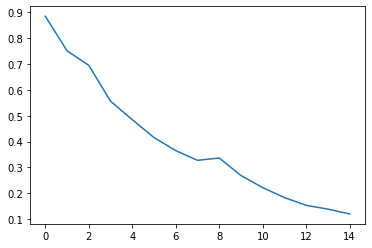

In [ ]:
plt.plot(TRAINING_LOSS)

In [ ]:
accuracy_hist = []
for d in ACCURACY:
    total_acc = 0
    for k,v in d.items():
        total_acc += v
    accuracy_hist.append(total_acc/len(d))
accuracy_hist

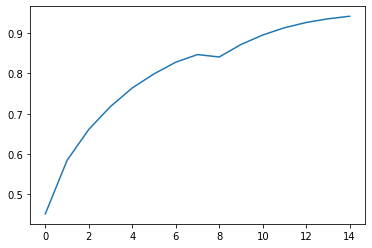

In [ ]:
plt.plot(accuracy_hist)

# NLI Validation

In [27]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(labels_dict),
    output_attentions=False,
    output_hidden_states=False
).to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [28]:
model.load_state_dict(torch.load('/content/drive/MyDrive/DLProject/NLI/NLI_BERT_epoch_15.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [29]:
_, predictions, true_vals = evaluate(dataloader_val)

In [30]:
#15 epochs
_, total = accuracy_per_class(predictions, true_vals, print=True)
print(f'Total Accuracy: {total:.3f}')

Class: German  |  Accuracy:  0.546

Class: Spanish  |  Accuracy:  0.797

Class: French  |  Accuracy:  0.602

Total Accuracy: 0.648


In [31]:
predicted_labels = np.argmax(predictions, axis=1).flatten()
predicted_labels

array([0, 1, 2, ..., 2, 2, 1])

In [32]:
len(validation_sentences) == len(predicted_labels)

True

# Translation Models

In [33]:
TRANS_ES = '/content/drive/MyDrive/DLProject/MLT_SPANISH/transformer.pth'
BPE_GER = '/content/drive/MyDrive/DLProject/MLT_GERMAN/bpe.model'
TRANS_GER = '/content/drive/MyDrive/DLProject/MLT_GERMAN/averaged_transformer_checkpoint.pth.tar'
PY_ES = '/content/drive/MyDrive/DLProject/MLT_SPANISH/models.py'
PY_GER = '/content/drive/MyDrive/DLProject/MLT_GERMAN/translate.py'
MODEL_GER = '/content/drive/MyDrive/DLProject/MLT_GERMAN/model.py'
ENC_FR = '/content/drive/MyDrive/DLProject/MLT_FRENCH/fr_encoder2.pth'
DEC_FR = '/content/drive/MyDrive/DLProject/MLT_FRENCH/fr_decoder2.pth'
PY_FR = '/content/drive/MyDrive/DLProject/MLT_FRENCH/mtl_fr.py'
INP_FR = '/content/drive/MyDrive/DLProject/MLT_FRENCH/input_lang2.pkl'
OUT_FR = '/content/drive/MyDrive/DLProject/MLT_FRENCH/output_lang2.pkl'

In [34]:
!cp $PY_GER $MODEL_GER $TRANS_GER $BPE_GER $PY_ES $ENC_FR $DEC_FR $PY_FR $INP_FR $OUT_FR . 

In [35]:
!pip install youtokentome

In [36]:
!pip install einops

In [55]:
def trans_ger(sentences):
    from translate import translate
    print('TRANSLATING 5 RANDOM SENTENCES TO GERMAN\n')
    sentences = sentences[:5]
    for sentence in sentences:
        best_hypothesis, all_hypotheses = translate(
            source_sequence=sentence,
        )
        print(f'{sentence}\t=>\t{best_hypothesis}')

In [62]:
def trans_fr(sentences):
    print('TRANSLATING 5 RANDOM SENTENCES TO FRENCH\n')
    import dill
    from mtl_fr import EncoderRNN, AttnDecoderRNN, normalizeString, evaluate as french_eval
    with open('input_lang2.pkl', 'rb') as in_strm:
        fr_inp = dill.load(in_strm)
    with open('output_lang2.pkl', 'rb') as in_strm:
        fr_out = dill.load(in_strm)
    hidden_size = 256
    enc = EncoderRNN(fr_inp.n_words, hidden_size).to(device)
    enc.load_state_dict(torch.load('./fr_encoder2.pth'))
    dec = AttnDecoderRNN(hidden_size, fr_out.n_words, dropout_p=0.1).to(device)
    dec.load_state_dict(torch.load('./fr_decoder2.pth'))
    for sentence in sentences[:2]:
        norm = normalizeString(sentence)
        words, _ = french_eval(enc, dec, norm, input_lang=fr_inp, output_lang=fr_out)
        print(f'{sentence}\t=>\t{" ".join(words)}')
    pass

In [63]:
def validate(valid_loader, model, criterion):
    model.eval()
    predictions = []
    for step, data_dict in enumerate(iter(valid_loader)):
        with torch.no_grad():
            src, tgt, src_key_padding_mask, tgt_key_padding_mask = (
                data_dict["ids1"],
                data_dict["ids2"],
                data_dict["masks_sent1"],
                data_dict["masks_sent2"],
            )
            src, src_key_padding_mask = src.to("cuda"), src_key_padding_mask.to("cuda")
            tgt, tgt_key_padding_mask = tgt.to("cuda"), tgt_key_padding_mask.to("cuda")
            memory_key_padding_mask = src_key_padding_mask.clone()
            tgt_inp = tgt[:, :-1]
            tgt_out = tgt[:, 1:].contiguous()
            tgt_mask = gen_nopeek_mask(tgt_inp.shape[1]).to("cuda")
            outputs = model(
                src,
                tgt_inp,
                src_key_padding_mask,
                tgt_key_padding_mask[:, :-1],
                memory_key_padding_mask,
                tgt_mask,
            )
            print(hi)
            print(outputs)
    #         loss, logits, label_ids = loss_logits_labels(inputs, outputs)
    #         predictions.append(logits)

    # predictions = np.concatenate(logits, axis=0)
    # preds_flat = np.argmax(preds, axis=1).flatten()
    # for i in range(val_len):
    #     print(f'{validation_sentences[i]} => {preds}')

def trans_es(sentences):
    pass
    # import torch.nn as nn
    # from torch.utils.data import Dataset
    # from torch.optim import Adam
    # from transformers import RobertaTokenizer
    # from models import ParallelLanguageDataset, LanguageTransformer, ScheduledOptim
    
    # sentences = sentences[:2]
    # PRE_TRAINED_MODEL_NAME = "distilroberta-base"
    # tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
    # valid_dataset = ParallelLanguageDataset(
    #     data_path_1=sentences,
    #     data_path_2=None,
    #     tokenizer=tokenizer,
    #     max_len=96,
    # )
    # valid_loader = DataLoader(
    #         valid_dataset,
    #         batch_size=1,
    #         shuffle=True,
    #         num_workers=2,
    #         pin_memory=True,
    # )
    # d_model = 512
    # num_encoder_layers = 6
    # num_decoder_layers = 6
    # dim_feedforward = 2048
    # nhead = 8
    # pos_dropout = 0.1
    # n_warmup_steps = 2000
    # trans_dropout = 0.1

    # model = LanguageTransformer(
    #         tokenizer.vocab_size,
    #         d_model,
    #         nhead,
    #         num_encoder_layers,
    #         num_decoder_layers,
    #         dim_feedforward,
    #         96,
    #         pos_dropout,
    #         trans_dropout,
    # ).to(device)

    # optim = ScheduledOptim(Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-09), d_model, n_warmup_steps)
    # criterion = nn.CrossEntropyLoss(ignore_index=0)
    # validate(valid_loader, model, criterion)


In [64]:
# GERMAN_SENTENCES = predicted_labels == labels_dict['German']
TRANSLATOR_DICT = {
    labels_dict['German']: trans_ger,
    labels_dict['French']: trans_fr,
    labels_dict['Spanish']: trans_es    
}
TRANSLATOR_DICT

{0: <function __main__.trans_ger>,
 1: <function __main__.trans_es>,
 2: <function __main__.trans_fr>}

In [65]:
SENTENCES_DICT = {
    labels_dict['German']: [],
    labels_dict['French']: [],
    labels_dict['Spanish']: []
}
SENTENCES_DICT

{0: [], 1: [], 2: []}

In [66]:
val_len = len(validation_sentences)
for i in range(val_len):
    SENTENCES_DICT[predicted_labels[i]].append(validation_sentences[i])
len(SENTENCES_DICT[0]), len(SENTENCES_DICT[1]), len(SENTENCES_DICT[2])

(1687, 5602, 2403)

In [67]:
for k,v in SENTENCES_DICT.items():
    print('\n----------------------------------------------------------------------------------------')
    TRANSLATOR_DICT[k](v)
    print('\n----------------------------------------------------------------------------------------\n')


----------------------------------------------------------------------------------------
TRANSLATING 5 RANDOM SENTENCES TO GERMAN

Hello,	=>	Hallo!
So i began to learn japanese - by myself.	=>	Also fing ich an, Japanisch zu lernen - von mir.
At the moment I can all the kana and about 200 kanji.	=>	Im Moment kann ich alle kana und etwa 200 kanji.
My english teacher can't really help me...	=>	Mein Englischlehrer kann mir nicht wirklich helfen...
こんばんは	=>	► Nachrichten 

----------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------
TRANSLATING 5 RANDOM SENTENCES TO FRENCH

I had for about four years english now.	=>	j ai les des des des . . . <EOS>
I feel guilty, but I don't know why.	=>	je ai simplement pourquoi je n connais . <EOS>

----------------------------------------------------------------------------------------


-------------------------------------------------